# Flat Field画像解析

### はじめに
顕微鏡写真から粒子などを自動カウントさせる際に、元の画像の明度のばらつきがあると閾値の設定が難しくなります。
そこで、あらかじめ背景の明度のばらつきを落とす処理が必要になります。その処理にはFlat Field補正が用いられれます。
PyhtonとOpenCVを用いて背景の画像処理について覚えとして記載します。

### Flat Field補正
#### 天体写真撮影（撮影時の補正）

Flat Field補正は、天体の撮影の際に用いられます。

参考1
[Starry Urban Sky](https://urbansky.sakura.ne.jp/lightframe.html)

参考2
[フラット補正処理とは？](http://hyperbolaoptics.com/2017/01/23/%E3%83%95%E3%83%A9%E3%83%83%E3%83%88%E8%A3%9C%E6%AD%A3%E5%87%A6%E7%90%86%E3%81%A8%E3%81%AF%EF%BC%9F/)

参考3
[フラットフレームの撮影方法](http://ryutao.main.jp/tips_howto5.html)

参考にあるように、

ライトフレーム(LF)：一切何の処理も行わず、撮ったそのままの画像

ダークフレーム(DF)：ライトフレームと同じ撮影条件でカメラにキャップをして外からの光が入らないようにした撮影画像

フラットレーム(FF)：ライトフレームと同じ撮影条件で、何も写っておらず、光の分布だけが記録された画像

これらの画像から補正画像を以下の様に画像処理します

補正画像：(LF-DF)/(FF-DF)

ちなみに分光測定での反射率測定でも同じ処理を行っています。

反射率 ＝（測定サンプルの反射強度　-　ダークフレーム）/（リファレンスの反射強度（例えばAlとか）-　ダークフレーム）

#### すでに得られている画像（撮影後）での処理

参考4
[背景除去について](https://waku-take-a.github.io/%25E8%2583%258C%25E6%2599%25AF%25E9%2599%25A4%25E5%258E%25BB%25E3%2581%25AB%25E3%2581%25A4%25E3%2581%2584%25E3%2581%25A6.html)

大体の場合、すでに画像があってこの画像から粒子の数を自動的にカウントしてほしいと頼まれるので、上記に説明したような処理はできません。
今ある画像から背景処理を行う必要があります。そこで、元画像からフラットフレームを作り出します。
フラットフレームは、元画像（ライトフレーム）にMeanフィルター処理を行い、元画像の平均輝度をかけます。（Meanフィルターは画素範囲を少し大きめにして細かい構造がなくなるようにします。）

補正画像：ライトフレーム（元画像）/ フラットフレーム（Meanフィルタ後の画像 × 平均輝度）


### 試した環境

Windows 10 Pro

anaconda

Python = 3.7

conda = 4.9

numpy = 1.18.5

opencv = 4.2.0 (conda-forgeからインストール)


### 実際

参考4に掲載されている画像データを利用してPythonでFlat Fieldを実装してみました。

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 処理前と処理後の比較のPlot
def bef_aft_img_show(img1,img2):
    print(f'average brightness:{img1.mean():.1f}, {img2.mean():.1f} ')
    plt.figure(figsize=(10,10))
    plt.subplot(121),plt.imshow(img1),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2),plt.title('After')
    plt.xticks([]), plt.yticks([])
    plt.show()

# ImageとHistgramのPlot
def image_hist_show(img):
    print(f'Shape:{img.shape},type:{img.dtype}')
    print(f'Average Brightness:{img.mean():.1f}')
    hist = cv2.calcHist([img],[0],None,[256],[0,256])

    plt.figure(figsize=(10,5))
    plt.subplot(121),plt.imshow(img),plt.title('Image')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.plot(hist),plt.title('Histgram')
    plt.show()



Shape:(256, 256),type:uint8
Average Brightness:111.5


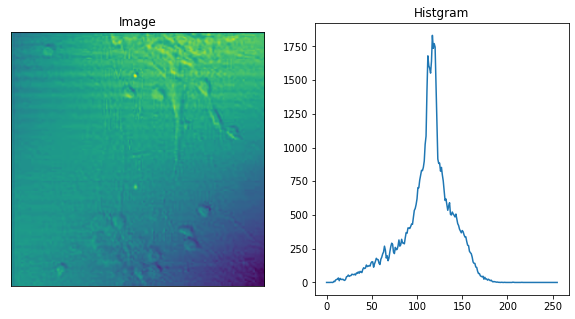

In [3]:
# 画像読み込み(OpenCVを利用しています)
file_path = './data/samp_Gradation1.bmp' # 適宜変更してください。
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
image_hist_show(img)


Shape:(256, 256),type:uint8
Average Brightness:111.7


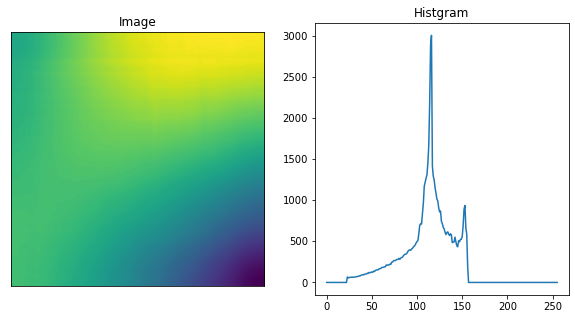

In [4]:
# Flat Frameの作成
# Meanフィルタリングを行う。
# 参考：画像の平滑化
# http://whitewell.sakura.ne.jp/OpenCV/py_tutorials/py_imgproc/py_filtering/py_filtering.html

dst = cv2.blur(img, (50, 50)) 
# 通常引数として(3,3)とか（5,5）を入力しますが、全体的な明暗を取り除くために大きい値にしている
# 適当に値を調整してください。

image_hist_show(dst)

float64
Shape:(256, 256),type:uint8
Average Brightness:110.3


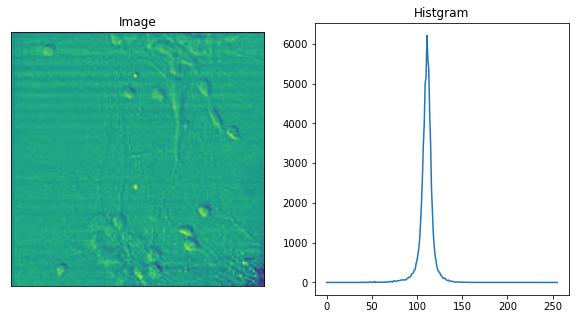

In [5]:
# 元画像 / Mean フィルタ後の画像 × 平均輝度
avg_hist = img.mean()
ffc = (img/dst)*avg_hist

print(ffc.dtype)
#　>>> float64
# float64になっているので、この後OpenCVの関数を利用するためにunit8にしています。
cast_ffc = ffc.astype('uint8')
image_hist_show(cast_ffc)

# この画像を保存する場合
# cv2.imwrite('case1_ffc.png', ffc)

average brightness:111.5, 110.3 


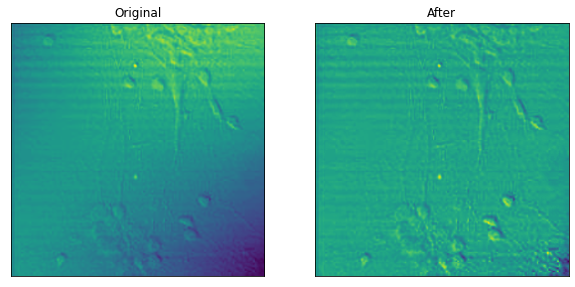

In [7]:
#処理前処理後の比較
bef_aft_img_show(img,cast_ffc)

Shape:(256, 256),type:uint8
Average Brightness:110.8


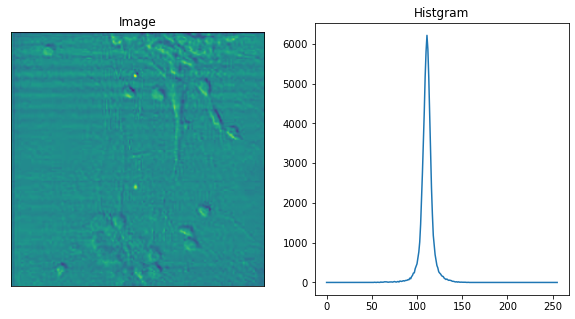

In [8]:
# 参考資料にあった、
# 元画像 － Mean フィルタ後の画像 ＋ 平均輝度　
# の処理である程度背景処理ができるならばそれでも良いと思います。

l_ffc = img - dst + avg_hist
cast_l_ffc = l_ffc.astype('uint8')
image_hist_show(cast_l_ffc)

ImgeJに実装されているrolling ball algorithmというものがあります

これについては、下記のサイトにPythonのパッケージがあります。

https://github.com/mbalatsko/opencv-rolling-ball

pipでしかインストールできません。
また、場合によっては、opencv-pythonもインストールされるので、このパッケージを試すならば、新しく仮想環境を作って試されたほうが良いと思います。実際に使ってみましたが、計算に少し時間がかかります。

Shape:(256, 256),type:uint8
Average Brightness:246.0


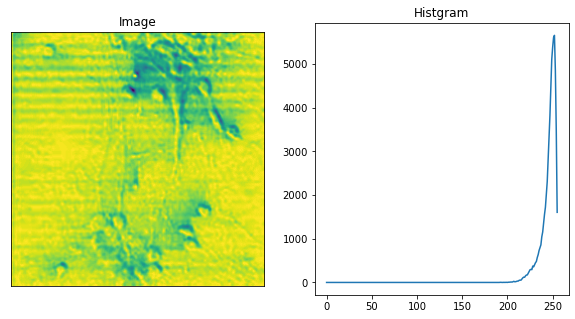

In [9]:
from cv2_rolling_ball import subtract_background_rolling_ball

img_rg, background = subtract_background_rolling_ball(img, 30, light_background=True,
                                     use_paraboloid=False, do_presmooth=True)

image_hist_show(img_rg)   